# Transformers
### Transformers is a supervised learning algorithm that processes sequential data using self-attention mechanisms to capture contextual relationships across all positions, making it ideal for tasks like sentiment analysis of movie reviews. It excels in classifying text sequences (e.g., determining positive or negative sentiment based on word context in IMDB reviews) and can handle various sequence tasks, requiring extensive pretraining and fine-tuning to optimize attention weights. The algorithm assumes that contextual dependencies are significant across the sequence, which enables effective pattern learning but may not hold for datasets with minimal sequential structure. Its strength lies in its ability to model long-range dependencies and generalize across tasks, but it can be computationally intensive, prone to overfitting without regularization, and sensitive to hyperparameter choices (e.g., attention heads, learning rate).

### Use Transformers as tool for sequence-based problems particularly in natural language processing or recommendation systems.

| Aspect | Details |
| :- | :- |
| Use For           | Sequence classification (e.g., sentiment analysis, machine translation)<br>Can be extended to text generation or question answering |
| Key Assumptions   | - Contextual dependencies exist across the sequence<br>- Independent observations<br>- Sufficient data for attention optimization |
| Advantages        | - Captures long-range dependencies with self-attention<br>- Highly effective for diverse NLP tasks<br>- Pretrained models available |
| Disadvantages     | - Computationally intensive during training and inference<br>- Prone to overfitting without regularization<br>- Sensitive to hyperparameter tuning |
| Avoid When        | - Datasets with minimal sequential structure<br>- Very small datasets with limited samples<br>- Real-time applications with low latency |
| Real-World Use Case | Sentiment analysis (e.g., classifying IMDB reviews as positive or negative)<br>Machine translation (e.g., translating languages in real-time) |

## Problem Description: 
### Classify movie reviews from the IMDB dataset as positive or negative sentiment based on the sequence of words, leveraging the attention mechanism of Transformers to capture contextual relationships. This is a binary classification problem where Transformers outperform traditional RNNs.

Using dataset https://www.tensorflow.org/datasets/catalog/imdb_reviews

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.datasets import imdb
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import string
import random
import os

In [167]:
project_dir = './17_transformers'

In [168]:
def setup_gpu():
    ## tf version
    print("TensorFlow version:", tf.__version__)

    #### GPU Optimisation code ####
    print("GPUs:",tf.config.list_physical_devices('GPU'))

    print("GPUs: Allocate GPU Memory and create a new session")

    # Get the GPU memory fraction to allocate
    gpu_memory_fraction = 0.5

    # Create GPUOptions with the fraction of GPU memory to allocate
    gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=gpu_memory_fraction)

    # Create a session with the GPUOptions
    session = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [169]:
setup_gpu()

TensorFlow version: 2.19.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPUs: Allocate GPU Memory and create a new session


I0000 00:00:1751393861.977219 2350575 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5119 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


In [170]:
# load the IMDB dataset
num_words = 40000 
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=num_words)
print("Training set shape:", len(X_train), "Test set shape:", len(X_test))

Training set shape: 25000 Test set shape: 25000


In [171]:
# preprocess the data (convert word indices back to text and tokenize)
max_length = 200  # max sequence length
X_train = pad_sequences(X_train, maxlen=max_length)
X_test = pad_sequences(X_test, maxlen=max_length)
print("Padded Train set shape:", X_train.shape, "Padded Test set shape:", X_test.shape)

Padded Train set shape: (25000, 200) Padded Test set shape: (25000, 200)


In [172]:
# split training data for validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print("Train set shape:", X_train.shape, "Validation set shape:", X_val.shape, "Test set shape:", X_test.shape)

Train set shape: (20000, 200) Validation set shape: (5000, 200) Test set shape: (25000, 200)


In [173]:
# define the Transformer model encoder
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # apply Layer Normalization
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = Add()([inputs, x])
    # apply Feed Forward Network
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1], kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    return Add()([res, x])

# define the Transformer model decoder
def transformer_decoder(inputs, enc_outputs, head_size, num_heads, ff_dim, dropout=0):
    # apply Layer Normalization and Multi-Head Attention
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, enc_outputs)
    x = Dropout(dropout)(x)
    res = Add()([inputs, x])
    # apply Feed Forward Network
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1], kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    return Add()([res, x])

In [174]:
# create the Transformer model
inputs = Input(shape=(max_length,))
x = Embedding(num_words, 32)(inputs)
x = Dropout(0.1)(x)
for _ in range(3):
    x = transformer_encoder(x, head_size=128, num_heads=12, ff_dim=128, dropout=0.5)

decoder_input = Input(shape=(max_length,))
dec_x = Embedding(num_words, 32)(decoder_input)
dec_x = Dropout(0.1)(dec_x)
for _ in range(3):
    dec_x = transformer_decoder(dec_x, x, head_size=128, num_heads=12, ff_dim=128, dropout=0.5)

dec_x = LayerNormalization(epsilon=1e-6)(dec_x)
dec_x = Flatten()(dec_x)
dec_x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1))(dec_x)
dec_x = Dropout(0.6)(dec_x)
outputs = Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.1))(dec_x)
transformer_model = Model(inputs=[inputs, decoder_input], outputs=outputs)

In [175]:
# compile the model with a custom learning rate
custom_optimizer = Adam(learning_rate=1e-6)
transformer_model.compile(optimizer=custom_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [176]:
# define callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

In [177]:
# train the Transformer model
history = transformer_model.fit([X_train, X_train], y_train, epochs=200, batch_size=16, 
                               validation_data=([X_val, X_val], y_val), 
                               callbacks=[early_stopping, reduce_lr], verbose=1)

Epoch 1/200
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 55s 28ms/step - accuracy: 0.5037 - loss: 19.8461 - val_accuracy: 0.5080 - val_loss: 19.2601 - learning_rate: 1.0000e-06
Epoch 2/200
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.5014 - loss: 19.2706 - val_accuracy: 0.5126 - val_loss: 18.7841 - learning_rate: 1.0000e-06
Epoch 3/200
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.5017 - loss: 18.7169 - val_accuracy: 0.4996 - val_loss: 18.2719 - learning_rate: 1.0000e-06
Epoch 4/200
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.4987 - loss: 18.1602 - val_accuracy: 0.5022 - val_loss: 17.6987 - learning_rate: 1.0000e-06
Epoch 5/200
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.4972 - loss: 17.5540 - val_accuracy: 0.5040 - val_loss: 17.0572 - learning_rate: 1.0000e-06
Epoch 6/200
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.5043 - loss: 16.8896 - val_accuracy: 0.5040 - val_loss: 16.3499 - learning_rate: 1.0000e-06
Epoch 7/200
1250/1250 

In [178]:
# predict and evaluate
y_pred = transformer_model.predict([X_test, X_test])
y_pred_classes = (y_pred > 0.7).astype(int).flatten()
accuracy = accuracy_score(y_test, y_pred_classes)
conf_matrix = confusion_matrix(y_test, y_pred_classes)

print(f'Accuracy: {accuracy:.2f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(classification_report(y_test, y_pred_classes, target_names=['Negative', 'Positive']))

782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step
Accuracy: 0.84
Confusion Matrix:
[[11241  1259]
 [ 2642  9858]]
Classification Report:
              precision    recall  f1-score   support

    Negative       0.81      0.90      0.85     12500
    Positive       0.89      0.79      0.83     12500

    accuracy                           0.84     25000
   macro avg       0.85      0.84      0.84     25000
weighted avg       0.85      0.84      0.84     25000



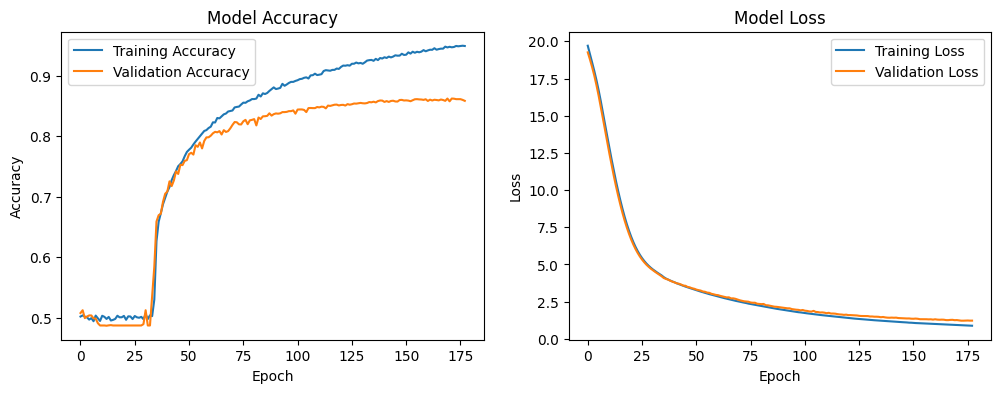

In [179]:
# visualize training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

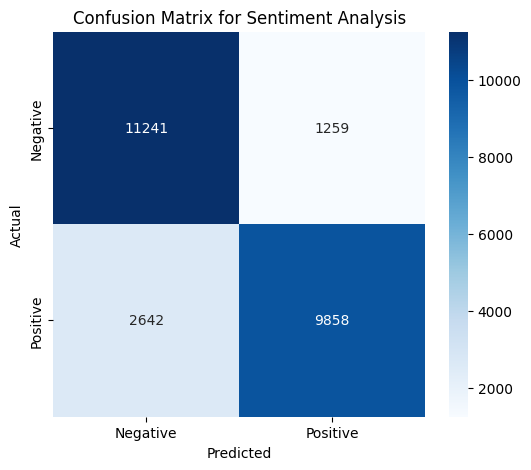

In [180]:
# visualize confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Sentiment Analysis')
plt.show()

In [181]:
# save the model in a 'model' subdirectory
model_dir = project_dir + '/model'
os.makedirs(model_dir, exist_ok=True)
model_filename = os.path.join(model_dir, 'imdb_transformer_model.h5')
transformer_model.save(model_filename)
print(f'Model saved as {model_filename}')

Model saved as ./17_transformers/model/imdb_transformer_model.h5


In [ ]:
# load the model and run a prediction test (using a sample review)
loaded_model = tf.keras.models.load_model(model_filename)
word_index = imdb.get_word_index()

# tokenize and preprocess the review
def preprocess_review(review):
    review = review.translate(str.maketrans('', '', string.punctuation))
    tokens = [word_index.get(word, 2) for word in review.lower().split() if word_index.get(word, 0) < num_words]
    return pad_sequences([tokens], maxlen=max_length)

# define 10 positive and 10 negative reviews
positive_reviews = [
    "This movie was absolutely fantastic and a joy to watch",
    "Incredible performances and a gripping storyline",
    "A masterpiece of cinema, highly recommended",
    "Really enjoyed the humor and heartwarming moments",
    "Brilliant direction and stunning visuals",
    "An inspiring and uplifting film experience",
    "The cast was phenomenal, loved every minute",
    "A truly engaging and emotional journey",
    "Fantastic plot twists, kept me on edge",
    "One of the best movies I've seen this year"
]
negative_reviews = [
    "Boring and predictable, a waste of time",
    "Terrible acting and a weak script",
    "Disappointing plot, lacked any depth",
    "Poorly directed with no coherence",
    "Awful dialogue, couldn't stay engaged",
    "A complete letdown, no redeeming qualities",
    "Dull and unoriginal, not worth watching",
    "Confusing storyline, felt like a mess",
    "Bad pacing and unconvincing characters",
    "Rubbish execution, totally forgettable"
]

# combine and shuffle reviews
all_reviews = [(review, "Positive") for review in positive_reviews] + [(review, "Negative") for review in negative_reviews]
random.shuffle(all_reviews)

# test reviews and store results
results = []
for review, true_label in all_reviews:
    sequence = preprocess_review(review)
    prediction = loaded_model.predict([sequence, sequence])
    pred_class = "Positive" if prediction[0][0] > 0.8 else "Negative"
    results.append({
        "Review": review,
        "True Label": true_label,
        "Predicted Label": pred_class,
        "Probability": prediction[0][0]
    })

# create results table
results_df = pd.DataFrame(results)
print("\nSentiment Prediction Results:")
print(results_df[["Review", "True Label", "Predicted Label", "Probability"]].to_string(index=False))

# count correct and incorrect predictions
correct_count = sum(1 for result in results if result["True Label"] == result["Predicted Label"])
incorrect_count = len(results) - correct_count
print(f"\nPrediction Summary:")
print(f"Correct Predictions: {correct_count}")
print(f"Incorrect Predictions: {incorrect_count}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

Sentiment Prediction Results:
                                                Review True Label Predicted Label  Probability
              Brilliant direction and stunning visuals   Positive        Negative     0.049072
                     

: 